In [1]:
import requests
import tarfile
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import zipfile
import pandas as pd

In [2]:
required_files = {
    "data": 
    {
        "link": 'https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        "zname": "dataset.tar.gz",
        "fname": "images"
    },
    "target":
    {
        "link": 'https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz',
        "zname": 'target.tar.gz',
        "fname": "target"
    }
}

In [3]:
# def download(url, file_name):
#   response = requests.get(url, stream=True)
#   if response.status_code == 200:
#       with open(file_name, 'wb') as f:
#           f.write(response.raw.read())

In [4]:
# def extract_tar(file_path, destination_path):
#   file = tarfile.open(file_path)
#   file.extractall(destination_path)
#   file.close()

In [5]:
# for key, value in required_files.items():
#   download(value["link"], value["zname"])
#   extract_tar(value["zname"], value["fname"])

In [6]:
# def extract_zip(s_path, d_path):
#   with zipfile.ZipFile(s_path, 'r') as zip_ref:
#       zip_ref.extractall(d_path)

In [7]:
def crop_image(image_path):
  img = Image.open(image_path)
  x_center = img.width/2
  y_center = img.height/2
  cr = img.crop((x_center-100, y_center-100, x_center+100, y_center+100))

  return cr

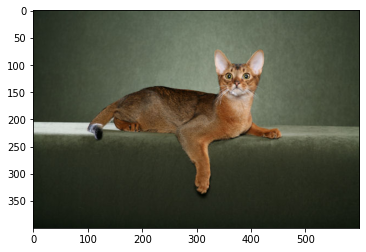

In [8]:
img = Image.open('content/Abyssinian_1.jpg')
plt.imshow(img)

In [9]:
os.listdir()

['.DS_Store',
 'list.txt',
 'images',
 'Project.ipynb',
 'content',
 'README.md',
 '.ipynb_checkpoints']

In [10]:
li = sorted(os.listdir('content'))
len(li)

2390

In [11]:
li = [name for name in li if name.split(".")[1]=="jpg" and name.split(".")[0][0].isupper()]

In [12]:
len(li)

2390

In [13]:
""" 
Things to fix:
  1. Remove images having (200,200,4)
  2. Remove images having (200,200)
"""

count_2 = 0
count_4 = 0
count = 0
to_remove = []
to_keep = []
for i, name in enumerate(li):
  img_path = f'content/{name}'
  crp_img = crop_image(img_path)
  crp_arr = np.array(crp_img)
  crp_arr = crp_arr.reshape(-1)
  if crp_arr.shape[0] == 200*200*3:
    # image_data[i] = crp_arr
    count += 1
    to_keep.append(img_path)
  elif crp_arr.shape[0] == 200*200:
    to_remove.append(img_path)
    count_2 += 1
  elif crp_arr.shape[0] == 200*200*4:
    to_remove.append(img_path)
    count_4 += 1

print(count, count_2, count_4)
print(to_remove)

2390 0 0
[]


In [14]:
# remove all other useless images from `images` folder
for i in os.listdir('content'):
  if i[0].islower() or i.split(".")[1] != "jpg":
    to_remove.append(f'content/{i}')

In [15]:
len(to_remove)

0

In [16]:
for path in to_remove:
  os.remove(path)

In [17]:
len(os.listdir('content'))

2390

In [18]:
# zf = zipfile.ZipFile("images.zip", "w")
# for dirname, subdirs, files in os.walk("/content/images"):
#     zf.write(dirname)
#     for filename in files:
#         zf.write(os.path.join(dirname, filename))
# zf.close()

## Making labels for Images

In [19]:
data = pd.read_csv("list.txt", sep=" ", header=None)
data = data[[0,3]]
data.columns = ['images', 'breed']
data = data.sort_values('images', ignore_index=True)

In [20]:
data.head()

,images,breed
0,Abyssinian_1,1
1,Abyssinian_10,1
2,Abyssinian_100,1
3,Abyssinian_101,1
4,Abyssinian_102,1


In [21]:
labels = {}

In [22]:
for i, img_path in enumerate(to_keep):
  name = img_path.split("/")[-1].split(".")[0]
  if not data[data['images'] == name]['breed'].empty:
    breed = data[data['images'] == name]['breed'].to_string(index=False).strip()
    labels[name] = breed

In [23]:
len(labels)

2368

In [24]:
# images data for training

images_for_train = list(labels.keys())
target = list(labels.values())

In [25]:
image_data = np.zeros((len(images_for_train), 200*200*3))

In [26]:
for i, img in enumerate(images_for_train):
  img_path = f'content/{img}.jpg'
  crp_img = crop_image(img_path)
  crp_img_arr = np.array(crp_img).reshape(-1)
  image_data[i] = crp_img_arr

In [27]:
image_data.shape

(2368, 120000)

In [28]:
target = np.array(target, dtype=np.int64)

In [29]:
target[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Training data:
- `image_data`
- `target`

## Model Training

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(image_data, target, test_size=0.4, random_state=42)

In [32]:
X_train.shape, X_train.dtype

((1420, 120000), dtype('float64'))

In [33]:
Y_train.shape, Y_train.dtype

((1420,), dtype('int64'))

In [34]:
scaler = StandardScaler()

In [35]:
X_train_transformed = scaler.fit_transform(X_train)

In [36]:
X_train_transformed[0,0], X_train[0,0]

(0.22914528558959024, 137.0)

In [48]:
model = LogisticRegression(max_iter=12000, C=1e2, n_jobs=-1)

In [49]:
model.fit(X_train_transformed, Y_train)

LogisticRegression(C=100.0, max_iter=12000, n_jobs=-1)

In [50]:
X_test_trans = scaler.transform(X_test)

In [51]:
model.score(X_train_transformed, Y_train)

1.0

In [52]:
model.score(X_test_trans, Y_test)

0.169831223628692

In [53]:
def prediction(X):
    X_trans = scaler.transform(X)
    return model.predict(X_trans)

In [54]:
i = 102
print(prediction([X_train_transformed[i]]), Y_train[i])

[4] 10


In [55]:
pred = model.predict(X_test_trans)

In [56]:
cm = confusion_matrix(Y_test, pred)
cm

array([[16,  8,  4,  4,  4,  2,  6,  7,  4,  2,  4,  7],
       [11,  5,  6,  2,  2,  6,  9, 19,  6,  6, 10, 16],
       [ 3,  1, 12,  5,  7,  8,  4,  6, 28,  4, 11,  4],
       [ 2,  1,  7, 22,  8,  1,  4,  6,  3,  5,  2,  3],
       [ 1,  4,  6,  9,  9,  2,  3,  4, 16, 11,  8,  5],
       [ 7,  2,  8,  1,  8, 11,  6,  4,  7,  4,  5,  3],
       [12,  2,  5,  1,  4,  5,  7, 12, 16,  3,  9,  7],
       [ 5,  0,  9,  1,  7,  0,  7, 19, 14,  2,  6,  8],
       [ 3,  2, 13,  2,  7,  3,  3,  6, 20,  4,  6,  4],
       [ 6,  1,  8, 11,  6,  3,  4,  8, 10, 14,  5,  6],
       [ 4,  2, 25,  5,  3,  4,  1,  4, 19,  6, 10,  6],
       [ 6,  0,  8,  3,  3,  2,  5, 20,  6,  4,  3, 16]])

In [57]:
import seaborn as sns

<AxesSubplot:>

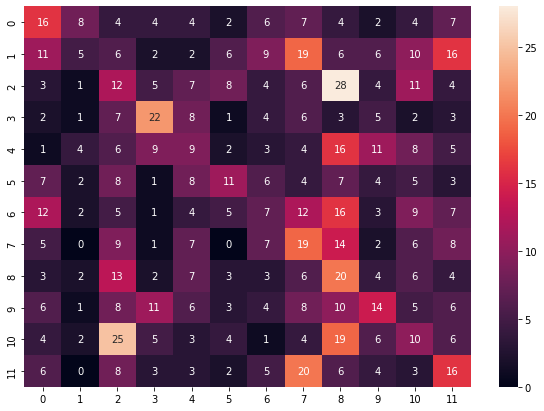

In [58]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)

https://datascience.stackexchange.com/questions/77813/logistic-regression-does-cannot-converge-without-poor-model-performance